# UMAP Decoder
If a dataset can be well separated by a UMAP dimensionality reduction, can I train a decoder network to return the original image from the UMAP encoding?

### Import data and dependencies

In [48]:
import torch
import os
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import ssl
import umap
import matplotlib.pyplot as plt
ssl._create_default_https_context = ssl._create_unverified_context

# We'll need this later... get it out the way now
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

model_path = f'./data/umap_decoder_model.pth' # For caching so as to not train over again

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split the data into training and test sets
train_data, test_data = train_test_split(mnist_data, test_size=0.2, random_state=42)
# Further split the test data into test and validation sets
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# MNIST data is given to us as [n, 1, 28, 28], which means we have:
# - n images, each of which has
# - 1 channel (grayscale), which is spread across
# - 28x28 pixels.
# Verify this with x_train.shape.
# We want a 2D array for each image, so we can use UMAP. This should
# be [n, channels x pixels x pixels] for data and [n] for labels.

def reshape_data(data):
    if len(data.shape) > 1: # multidimensional data
        num_samples = data.shape[0]
        num_features = data.shape[1] * data.shape[2] * data.shape[3]
        return data.view(num_samples, num_features)
    return data

# Extract the data and labels, then reshape the data
x_train = reshape_data(torch.stack([data[0] for data in train_data]))
y_train = reshape_data(torch.tensor([data[1] for data in train_data]))
x_test = reshape_data(torch.stack([data[0] for data in test_data]))
y_test = reshape_data(torch.tensor([data[1] for data in test_data]))
x_val = reshape_data(torch.stack([data[0] for data in val_data]))
y_val = reshape_data(torch.tensor([data[1] for data in val_data]))

# Print the shapes of the datasets
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

x_train shape: torch.Size([48000, 784])
y_train shape: torch.Size([48000])
x_test shape: torch.Size([6000, 784])
y_test shape: torch.Size([6000])
x_val shape: torch.Size([6000, 784])
y_val shape: torch.Size([6000])


### Create a UMAP Visualization

Verify that the MNIST dataset can, in fact, be separated cleanly by a UMAP dimensionality reduction

In [49]:
# Use no random seed so we get parallelism
umapper = umap.UMAP(n_components=2)
x_train_umapped_for_plot = umapper.fit_transform(x_train)

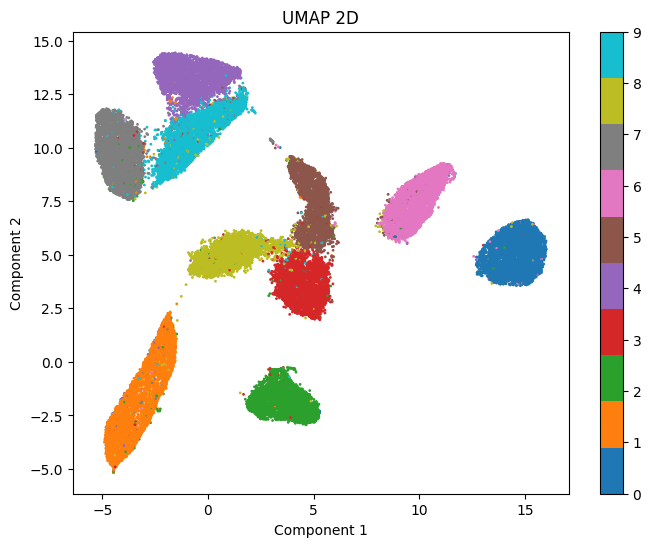

In [50]:
def plot_embedding_2d(data, y, title):
    # `data` is a 2D array of shape (n_samples, n_reduced_dimensions)
    # `y` is a 1D tensor of shape (n_samples), representing the labels
    y = y.numpy() # convert to numpy array to make matplotlib happy

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        # Value of data in the first dimension
        data[:, 0],
        # Value of data in the second dimension
        data[:, 1],
        # Color of each point, representing the label
        c=y.astype(int),
        # Use a categorical color map with 10 distinct colors
        cmap="tab10",
        # size of each point
        s=1,
    )
    # Add a color bar to the right of the plot
    plt.colorbar(scatter)

    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    plt.show()

# Plot the UMAP projection
plot_embedding_2d(x_train_umapped_for_plot, y_train, title="UMAP 2D")

### Create a decoder network

It looks like UMAP *does* in fact separate this data quite nicely, so let's try constructing a decoder network and training it to get our original images back!

In [51]:
def normalize_data(data):
    normalize = transforms.Normalize((0.5,), (0.5,))
    return normalize(torch.tensor(data).view(data.shape[0], 2, 1, 1)).view(-1, 2)

x_train_umapped = normalize_data(x_train_umapped_for_plot)
x_test_umapped  = normalize_data(umapper.transform(x_test))
x_val_umapped   = normalize_data(umapper.transform(x_val))

# Now let's shove them in data loaders for easier syntax in our training loop
def make_data_loader(x, y, batch_size=128):
    dataset = torch.utils.data.TensorDataset(x, y)
    return torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# Note that our 'labels' are our original images, NOT the actual y labels (categories)
train_loader = make_data_loader(x_train_umapped, x_train)
test_loader = make_data_loader(x_test_umapped, x_test)
val_loader = make_data_loader(x_val_umapped, x_val)

In [52]:
# Linear-Tanh Autodecoder
class Autodecoder_FC(nn.Module):
    def __init__(self, n_inputs=2):
        super(Autodecoder_FC, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(n_inputs, 8),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [53]:
# Configuration:
num_epochs = 100
learning_rate = 0.00001

## Define a training loop

In [54]:
def train_model(model):
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    epoch_losses, validation_losses = [], []
    best_val_loss = float('inf')
    trigger_times = 0
    patience = 5

    for epoch in range(num_epochs):
        model.train()
        for umapped_img, original_img in train_loader:
            umapped_img, original_img = umapped_img.to(device), original_img.to(device)
            # Forward pass
            output_img = model(umapped_img)
            loss = criterion(output_img, original_img)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_losses.append(loss.item())

        # Calculate validation loss
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for umapped_img, original_img in val_loader:
                umapped_img, original_img = umapped_img.to(device), original_img.to(device)
                output_img = model(umapped_img)
                loss = criterion(output_img, original_img)
                validation_loss += loss.item()

        validation_loss /= len(val_loader)
        validation_losses.append(validation_loss)
        msg = f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.5f} Validation Loss: {validation_loss:.5f}"

        # Early stopping logic
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            trigger_times = 0
            print(msg)
        else:
            trigger_times += 1
            print(msg + '*') # to mark an epoch with no decrease in validation loss
            if trigger_times >= patience:
                print("Early stopping!")
                break

    plt.figure()
    plt.plot(epoch_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Train or load the model

In [55]:
RETRAIN_MODEL = False

model_path = f'./data/umap_decoder_model_smaller.pth'

if RETRAIN_MODEL or not os.path.exists(model_path):
    model = Autodecoder_FC().to(device)
    train_model(model)
    torch.save(model, model_path)
model = torch.load(model_path)

/var/folders/00/y7vrtr4x025b9qwylgvvj0zr0000gn/T/ipykernel_46243/173187960.py:9: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



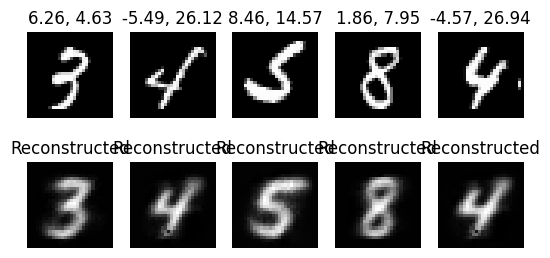

In [56]:
# Print a few examples
model.eval()
with torch.no_grad():
    # Visualize the first 5 images
    for umapped_imgs, original_imgs in test_loader:
        output_imgs = model(umapped_imgs.to(device))
        for i in range(5):
            x, y = umapped_imgs[i]
            plt.subplot(3, 5, i + 1)
            plt.imshow(original_imgs[i].cpu().reshape(28, 28), cmap="gray")
            plt.title(f"{x:.2f}, {y:.2f}")
            plt.axis("off")

            plt.subplot(3, 5, i + 6)
            plt.imshow(output_imgs[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Reconstructed")
            plt.axis("off")
        plt.show()
        break


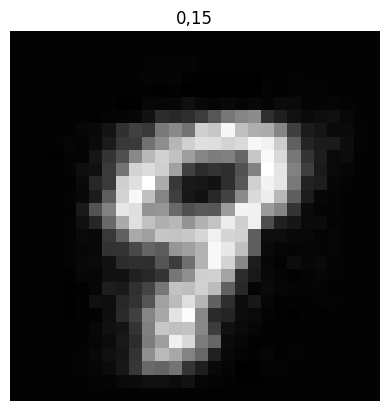

In [57]:
def predict(model, x, y):
    input = torch.tensor([[float(x), float(y)]])
    model.eval()
    with torch.no_grad():
        output_imgs = model(input.to(device))
        plt.imshow(output_imgs[0].cpu().reshape(28, 28), cmap="gray")
        plt.title(f"{x},{y}")
        plt.axis("off")
        plt.show()

predict(model, 0, 15)

In [58]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import torch
import numpy as np
from plotly.subplots import make_subplots

# Define the predict function
def predict(model, x, y):
    # input = torch.tensor([[float(x), float(y)]])
    input = torch.tensor([[
        float((x - 0.5)/0.5),
        float((y - 0.5)/0.5)
    ]])
    model.eval()
    with torch.no_grad():
        output_imgs = model(input.to(device))
        return np.flipud(output_imgs[0].cpu().reshape(28, 28).numpy())

# Define the plot_embedding_2d function with interactive capabilities
def plot_embedding_2d_interactive(data, y, title, model):
    y = y.numpy()  # Convert to numpy array to make plotly happy

    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=(title, "Reconstructed"))

    # Left plot: UMAP projection
    scatter = go.Scatter(
        x=data[:, 0],
        y=data[:, 1],
        mode='markers',
        marker=dict(
            color=y.astype(int),
            colorscale='Viridis',
            size=5,
        ),
        hoverinfo='x+y',
    )
    fig.add_trace(scatter, row=1, col=1)

    # Right plot: Placeholder for the predicted image
    img = np.zeros((28, 28))
    heatmap = go.Heatmap(
        z=img,
        colorscale='Gray',
        showscale=False,
    )
    fig.add_trace(heatmap, row=1, col=2)

    # Update layout
    fig.update_layout(
        title_text=title,
        hovermode='closest',
    )

    return fig

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

# Assuming x_train_umapped_for_plot and y_train are defined
fig = plot_embedding_2d_interactive(x_train_umapped_for_plot, y_train, title="UMAP 2D", model=model)

# Create Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='umap-plot', figure=fig),
])

@app.callback(
    Output('umap-plot', 'figure'),
    [Input('umap-plot', 'hoverData')]
)
def update_image(hoverData):
    if hoverData is None:
        return fig

    point = hoverData['points'][0]
    x_mouse = point['x']
    y_mouse = point['y']
    reconstructed_img = predict(model, x_mouse, y_mouse)
    heatmap = go.Heatmap(
        z=reconstructed_img,
        colorscale='Gray',
        showscale=False,
    )
    fig.data[1].z = reconstructed_img
    fig.data[1].zmin = reconstructed_img.min()
    fig.data[1].zmax = reconstructed_img.max()
    fig.update_traces(z=fig.data[1].z, selector=dict(type='heatmap'))
    fig.layout.annotations[1].text = f"Reconstructed ({x_mouse:.2f}, {y_mouse:.2f})"
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

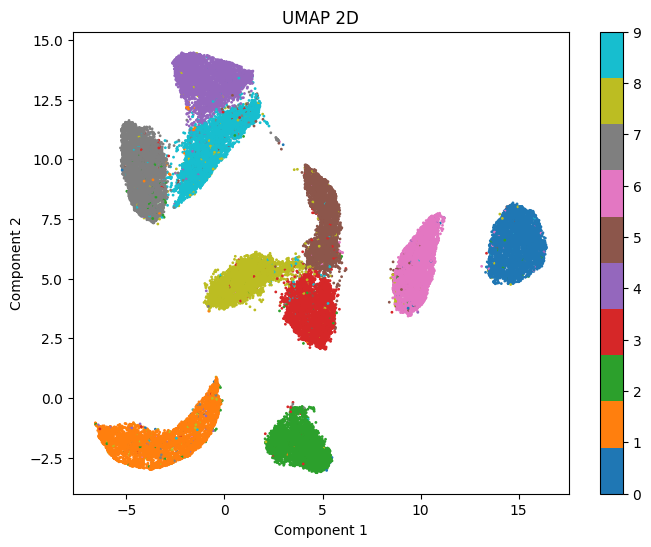

In [32]:
plot_embedding_2d(x_train_umapped_for_plot, y_train, title="UMAP 2D")